In [1]:
from sklearn import cluster
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import geopandas as gpd
import re as reg
import random
#from yellowbrick.cluster import KElbowVisualizer

Matplotlib is building the font cache; this may take a moment.


In [2]:
from yellowbrick.cluster import KElbowVisualizer

In [4]:
user='S'

if user=='S':
    mandat_dep=pd.read_csv("C:/Users/sylva/Desktop/git/Projet-Python-deputes/liste_mandat.csv")#on récupère le csv de la liste des mandats
    df_depu=pd.read_csv("C:/Users/sylva/Desktop/git/Projet-Python-deputes/listeDepute_complete.csv")
    ddpartement=pd.read_csv("C:/Users/sylva/Desktop/git/Projet-Python-deputes/table_dpmt.csv")

if user=='G':
    mandat_dep=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/liste_mandatdef.csv") 
    df_depu=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/listeDepute_complete.csv")
    ddpartement=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/table_dpmt.csv")

Essayons de faire un clustering sur les département selon leur orientation politique sous la troisième république

In [5]:
mandat_dep_3=mandat_dep[mandat_dep['Régime politique']=='Troisième République - Chambre des députés']
def datagroupe(mandat_reg) :
    liste_groupe=mandat_reg['Groupe'].unique()
    gros_groupe=[]
    for groupe in liste_groupe :
        if mandat_reg[mandat_reg['Groupe']==groupe]['Groupe'].count()>10 :
            gros_groupe+=[groupe]#on va se concentrer sur les gros groupes pour diminuer la complexité
    datadep=[]
    for departement in mandat_reg['Département'].unique():
        newdep=[]
        dep=mandat_reg[mandat_reg['Département']==departement]
        nbremand=dep['Groupe'].count()
        for groupe in gros_groupe :
            pct_groupe=dep[dep['Groupe']==groupe]['Groupe'].count()/nbremand#pourcentage de députés du département issu de ce groupe
            newdep+=[pct_groupe]#on rajoute les données du groupe dans le dataframe du département
        datadep+=[newdep]#on rajoute les données du département au futur dataframe général 
    datadep=np.array(datadep)#on crée un dataframe avec les informations
    depmt_groupe = pd.DataFrame(datadep, index=mandat_reg['Département'].unique(),columns=gros_groupe)
    return depmt_groupe, gros_groupe
(depmt_groupe_3, gros_groupe_3)=datagroupe(mandat_dep_3)
depmt_groupe_3

,Socialiste,Gauche indépendante,Fédération républicaine de France,Républicain radical et radical-socialiste,Non inscrit,Républicains indépendants et d'action sociale,Indépendants d'action populaire,Communiste,Indépendants de gauche,Gauche démocratique et radicale indépendante,...,Radical,Extreme-gauche,Appel au peuple,Centre gauche,Gauche,Union conservatrice,Opportuniste,Centre droit,Extrême-droite,Union des gauches
Deux-Sèvres,0.012346,0.000000,0.012346,0.098765,0.012346,0.012346,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.024691,0.012346,0.0,0.0,0.000000,0.000000,0.000000,0.0
Finistère,0.013158,0.000000,0.013158,0.059211,0.039474,0.013158,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.000000,0.059211,0.0,0.0,0.000000,0.000000,0.013158,0.0
Hautes-Alpes,0.020408,0.020408,0.000000,0.000000,0.081633,0.000000,0.0,0.00000,0.000000,0.020408,...,0.0,0.0,0.000000,0.040816,0.0,0.0,0.040816,0.000000,0.000000,0.0
Meurthe-et-Moselle,0.000000,0.000000,0.022222,0.011111,0.033333,0.011111,0.0,0.00000,0.011111,0.011111,...,0.0,0.0,0.000000,0.011111,0.0,0.0,0.000000,0.000000,0.000000,0.0
Somme,0.016260,0.000000,0.000000,0.032520,0.032520,0.000000,0.0,0.01626,0.000000,0.000000,...,0.0,0.0,0.016260,0.048780,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orne,0.000000,0.000000,0.013158,0.000000,0.013158,0.013158,0.0,0.00000,0.000000,0.026316,...,0.0,0.0,0.092105,0.105263,0.0,0.0,0.000000,0.000000,0.000000,0.0
Territoire-de-Belfort,0.000000,0.000000,0.043478,0.130435,0.043478,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
Tarn-et-Garonne,0.023256,0.000000,0.000000,0.139535,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.069767,0.046512,0.0,0.0,0.000000,0.046512,0.000000,0.0
La Réunion,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.0,0.00000,0.153846,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


C:\Users\sylva\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

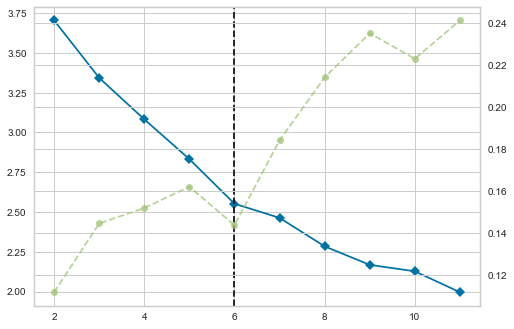

In [44]:
visualizer = KElbowVisualizer(kmeans, k=(2,12))
visualizer.fit(depmt_groupe_3)   

In [6]:
kmeans = cluster.KMeans(n_clusters=2, max_iter=1000)#comme il y a beaucoup de variables et pas trop de données, on peut augmenter le nombre d'itérations.
def clustering(depmt_groupe):
    kmeans.fit(depmt_groupe)
    idk = np.argsort(kmeans.labels_)#on trie les index
    #affichage des observations et leurs groupes
    clusters=pd.DataFrame(kmeans.labels_[idk], depmt_groupe.index[idk], columns=['Appartenance'])
    depmt_app=depmt_groupe.merge(clusters, right_index=True, left_index=True)
    #distances aux centres de classes des observations
    dist_centre=kmeans.transform(depmt_groupe)
    print(dist_centre.mean())
    return depmt_app
depmt_app_3=clustering(depmt_groupe_3)#les départements sont en moyenne plus proches d'un centre que de l'autre : bonne nouvelle ! Deux groupes relativement distincts a priori !
    

0.2153585591153429


In [7]:
centres=pd.DataFrame(kmeans.cluster_centers_, index=['0','1'],columns=gros_groupe_3)
pd.set_option('display.max_columns', None)#on peut observer tous les partis ainsi

display(centres)

,Socialiste,Gauche indépendante,Fédération républicaine de France,Républicain radical et radical-socialiste,Non inscrit,Républicains indépendants et d'action sociale,Indépendants d'action populaire,Communiste,Indépendants de gauche,Gauche démocratique et radicale indépendante,Gauche radicale,Alliance des républicains de gauche et des radicaux indépendants,Parti socialiste,Députés indépendants,Indépendants,Indépendants républicains,Union républicaine démocratique,Républicains de gauche,Union socialiste et républicaine,Fédération républicaine,Démocrate populaire,Députés du centre républicain,Parti socialiste de France,Radical et radical-socialiste,Parti républicain socialiste et socialiste français,Parti républicain socialiste,Parti socialiste français,Démocrates populaires,Républicain et social,Démocrates,Gauche républicaine démocratique,Action démocratique et sociale,Entente républicaine démocratique,Gauche sociale et radicale,Action républicaine et sociale,Républicain socialiste,Républicain socialiste et socialiste français,Union républicaine radicale et socialiste,Parti radical et radical socialiste,Gauche démocratique,Parti républicain radical et radical socialiste,Républicains radicaux-socialistes,Action libérale,Républicain progressiste,Gauche radicale-socialiste,Socialistes parlementaires,Droites,Socialistes unifiés,Union démocratique,Gauche démocratique,Républicains progressistes,Radical-socialiste,Progressiste,Union républicaine,Défense nationale,Républicains nationalistes,Républicain radical,Union des Droites,Républicain,Républicain,Extrême-gauche,Gauche républicaine,Radical,Extreme-gauche,Appel au peuple,Centre gauche,Gauche,Union conservatrice,Opportuniste,Centre droit,Extrême-droite,Union des gauches
0,0.008593,0.005353,0.010951,0.045831,0.035400,0.004076,1.026852e-02,0.005574,0.005563,0.004620,0.068684,0.005903,0.028846,0.011123,0.008559,0.001357,0.038231,0.034497,0.003455,0.013525,0.007734,0.004274,0.001770,0.015341,0.001694,0.001535,0.001555,0.005684,0.003020,0.004999,0.018939,0.002713,0.034189,0.000381,0.004306,0.007000,0.003049,0.001928,0.007649,0.017020,0.017386,0.012272,0.039249,0.013699,0.010668,0.000958,0.008141,0.002029,0.014375,0.010623,0.029394,0.007254,0.009975,0.036054,0.004556,0.004350,0.004456,0.119945,0.004844,0.003880,1.734723e-18,0.030107,-6.505213e-19,4.336809e-19,0.048531,0.030278,0.000989,0.003221,0.003080,0.004489,0.002378,0.002733
1,0.027208,0.003919,0.001264,0.067219,0.018446,0.001935,5.204170e-18,0.008225,0.006597,0.004223,0.124150,0.004557,0.069025,0.003884,0.003647,0.000465,0.011434,0.020792,0.004777,0.003965,0.000735,0.002316,0.003835,0.022597,0.001850,0.001941,0.001742,0.000270,0.000905,0.000220,0.014184,0.002778,0.015303,0.002397,0.003545,0.020302,0.007355,0.003350,0.015544,0.014746,0.025385,0.022427,0.007051,0.007194,0.028775,0.014321,0.000409,0.005591,0.016510,0.014470,0.023298,0.031915,0.004756,0.095740,0.000517,0.002007,0.012764,0.010230,0.003254,0.004244,1.772030e-02,0.059442,3.081498e-03,2.191206e-03,0.006728,0.021381,0.001391,0.000000,0.003982,0.002371,0.000339,0.001912


In [8]:
plusgrandecart=centres.T
plusgrandecart['ecart']=plusgrandecart['0']-plusgrandecart['1']
plusgrandecart.sort_values(by='ecart')

,0,1,ecart
Union républicaine,0.036054,0.095740,-0.059686
Gauche radicale,0.068684,0.124150,-0.055467
Parti socialiste,0.028846,0.069025,-0.040179
Gauche républicaine,0.030107,0.059442,-0.029335
Radical-socialiste,0.007254,0.031915,-0.024660
...,...,...,...
Entente républicaine démocratique,0.034189,0.015303,0.018886
Union républicaine démocratique,0.038231,0.011434,0.026797
Action libérale,0.039249,0.007051,0.032198
Appel au peuple,0.048531,0.006728,0.041803


Les écarts les plus importants en faveur de l'un des centres correspondent à des partis à droite, tandis que ceux en faveur de l'autre correspondent à des partis de gauche : le clustering semble donc avoir séparé un groupe de départements plus à droite et un autre plus à gauche. 

In [9]:
#récupération d'une carte des départements français
import requests
import tempfile
import zipfile
temporary_location = tempfile.gettempdir()
def download_unzip(url, dirname =temporary_location, destname = "borders"):#fonction qui dézippe
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref: 
        zip_ref.extractall(dirname + '/' + destname)
download_unzip('https://www.data.gouv.fr/fr/datasets/r/3096e551-c68d-40ce-8972-a228c94c0ad1')#l'URL où on trouve les départements
carte_departement = gpd.read_file(tempfile.gettempdir() + "/borders/departements-20140306-100m.dbf")#on va chercher le fichier là où on l'a stocké
carte_metrop = carte_departement.loc[0:95]#on enlève les départements d'outre-mer pour avoir une carte lisible
carte_metrop.set_index('nom', inplace=True)#on met le nom du département en index pour pouvoir joindre les bases
carte_metrop_5=carte_metrop.copy()

In [10]:
depmt_app_3.index=[i[1:] for i in depmt_app_3.index]#on commence par enlever l'espace qui est au début du nom des départements
ind_val=carte_metrop.index.values#on remplace les anciens noms de département par les actuels
ind_val[ind_val=="Côtes-d'Armor"]='Côtes-du-Nord'#et on traite chaque cas de changement de nom
ind_val[ind_val=="Seine-Maritime"]='Seine-Inférieure'
ind_val[ind_val=="Alpes-de-Haute-Provence"]='Basses-Alpes'
ind_val[ind_val=="Loire-Atlantique"]='Loire-Inférieure'
ind_val[ind_val=="Pyrénées-Atlantiques"]='Basses-Pyrénées'
ind_val[ind_val=="Charente-Maritime"]='Charente-Inférieure'
ind_val[ind_val=="Hauts-de-Seine"]='Seine'
ind_val[ind_val=="Paris"]='Seine'
ind_val[ind_val=="Seine-Saint-Denis"]='Seine'
ind_val[ind_val=="Val-de-Marne"]='Seine'
ind_val[ind_val=="Haute-Corse"]='Corse'
ind_val[ind_val=="Corse-du-Sud"]='Corse'
ind_val[ind_val=="Essonne"]='Seine-et-Oise'
ind_val[ind_val=="Val-d'Oise"]='Seine-et-Oise'
ind_val[ind_val=="Yvelines"]='Seine-et-Oise'

<AxesSubplot:>

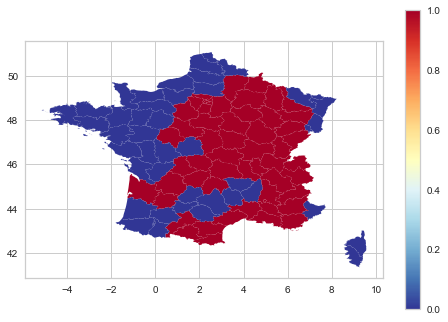

In [11]:
df = carte_metrop.merge(depmt_app_3, how = 'inner', left_index=True, right_index=True)
df.plot(column = 'Appartenance', cmap = 'RdYlBu_r', legend=True)#on crée des cartes

On vérifie la pertinence des groupes avec une ACP

In [12]:
acp=PCA(n_components=2)
proj=acp.fit_transform(depmt_groupe_3)
#Fit et réduit

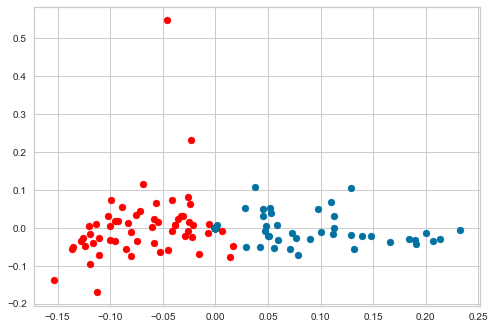

In [13]:
def nuagepoint(base, nbre_cluster=2) :
    proj0=[i[0] for i in proj]#on prend la projection sur l'axe des abcisses
    proj1=[i[1] for i in proj]#puis des ordonnées
    appartenance=np.array(base['Appartenance'])
    if nbre_cluster>2 :#avec des couleurs aléatoires
        for num_cluster in range(nbre_cluster) :
            appartenance=np.array((base['Appartenance']==num_cluster).astype(float))
            plt.scatter(proj0*appartenance, proj1*appartenance)#on projette les données du cluster
    else :#on prend les couleurs rouge et bleu
        plt.scatter(proj0*appartenance, proj1*appartenance, color='red')#on projette en rouge les membres du cluster 1
        plt.scatter(proj0*(1-appartenance), proj1*(1-appartenance))#en bleu ceux du 0
nuagepoint(depmt_app_3)#il y a juste n points en plus en (0,0), mais ils ne gênent pas la vision 

Le clustering semble bien avoir séparé deux groupes différents, dont un qui semble expliquer une très grande part des différences et qui semble bien être l'axe droite-gauche.

On refait pour la Cinquième République

In [14]:
mandat_dep_5=mandat_dep[mandat_dep['Régime politique']=='Cinquième République - Assemblée nationale']
(depmt_groupe_5, gros_groupe_5)=datagroupe(mandat_dep_5)

C:\Users\sylva\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


In [15]:
kmeans = cluster.KMeans(n_clusters=3, max_iter=1000)
depmt_app_5=clustering(depmt_groupe_5.fillna(0))
centres=pd.DataFrame(kmeans.cluster_centers_, index=['0','1', '2'],columns=gros_groupe_5)
pd.set_option('display.max_columns', None)
display(centres)

0.4413393337703826


,Union pour la majorité présidentielle,Union pour un mouvement populaire,La République en Marche,Socialiste,Union pour un Mouvement Populaire,Les Républicains,Nouvelle Gauche,Rassemblement pour la République,Mouvement Démocrate et apparentés,Non inscrit,Union des démocrates et indépendants,Communiste,Union pour la démocratie française,Nouveau Centre,Union pour la démocratie française et du centre,Gauche démocrate et républicaine,Socialiste,Front national,Communistes et républicains,Apparenté socialiste,République et liberté,Union du centre,Parti socialiste et radicaux de gauche,Union des démocrates pour la République,Union centriste,Républicains indépendants,Union des démocrates pour la République,Union démocratique pour la V° République,Réformateurs démocrates sociaux,Fédération de la gauche démocrate et socialiste,Progrès et démocratie moderne,Union pour la nouvelle République-UDT,Centre démocratique,Union pour la nouvelle République,Républicains populaires et centre démocratique,Unité de la République,Indépendants et paysans d'action sociale,Entente démocratique,Rassemblement démocratique
0,0.040264,6.479146e-02,0.012129,0.022672,4.937844e-03,0.022241,0.000783,1.164527e-01,0.002969,0.036335,0.004255,0.010928,0.080439,2.918586e-03,0.026259,0.001519,0.053014,1.439876e-03,0.000592,1.197009e-02,0.003238,0.003286,0.004354,0.064976,0.008088,0.032805,0.001241,0.035120,4.231750e-03,9.245736e-03,1.246457e-02,0.030056,1.194351e-02,0.023678,0.009771,8.982351e-03,0.013131,0.003916,0.005571
1,0.000000,6.938894e-18,0.000000,0.028469,8.673617e-19,0.000000,0.000000,1.387779e-17,0.000000,0.000000,0.000000,0.043394,0.000000,4.336809e-19,0.000000,0.000000,0.000000,4.336809e-19,0.000000,1.734723e-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.673617e-19,3.469447e-18,1.734723e-18,0.029851,1.734723e-18,0.736042,0.000000,0.000000e+00,0.106689,0.055556,0.000000
2,0.037952,3.525003e-02,0.010973,0.142680,4.638105e-03,0.004200,0.004689,1.038455e-01,0.004054,0.022676,0.001585,0.071186,0.045308,1.841637e-03,0.028784,0.007414,0.181044,3.091920e-03,0.002972,1.028213e-02,0.003461,0.001722,0.027562,0.053745,0.001834,0.016485,0.004929,0.016435,5.580124e-03,4.346552e-02,7.985506e-03,0.019331,3.362351e-03,0.018613,0.005913,-7.806256e-18,0.014485,0.005246,0.009008


Pour la Cinquième République, les résultats sont beaucoup moins encourageants. Il y a beaucoup plus de valeurs manquantes, ce qui enlève de l'intérêt au clustering : les valeurs sont artificiellement proches de 0. On va essayer d'en refaire un en se concentrant sur les premières législatures.

In [16]:
listeLegis=['Ire','IIe', 'IIIe', 'IVe', 'Ve', 'VIe', 'VIIe', 'VIIIe', 'IXe', 'Xe', 'XIe', 'XIIe']
listeLegislature=[' '+i+' législature ' for i in listeLegis]#on crée une liste des législatures dans le bon ordre
mandat_dep_5b=mandat_dep[mandat_dep['Régime politique']=='Cinquième République - Assemblée nationale']
mandat_dep_prems=mandat_dep_5b[mandat_dep_5b['Législature']==listeLegislature[0]]
for legislature in listeLegislature :
    mandat_dep_prems=pd.concat((mandat_dep_prems, mandat_dep_5b[mandat_dep_5b['Législature']==legislature]))
    
(depmt_groupe_5b, gros_groupe_5b)=datagroupe(mandat_dep_prems)

C:\Users\sylva\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


In [17]:
depmt_groupe_5b=depmt_groupe_5b[depmt_groupe_5b.index.notna()]
depmt_groupe_5b.index=[i[1:] for i in depmt_groupe_5b.index]#on commence par enlever l'espace qui est au début du nom des départements
depmt_groupe_5metr=carte_metrop_5.merge(depmt_groupe_5b, how = 'inner', left_index=True, right_index=True)#on enlève les députés hors france métropolitaine
depmt_groupe_5metr.drop(['code_insee', 'nuts3', 'wikipedia', 'geometry'], axis='columns', inplace=True)


C:\Users\sylva\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

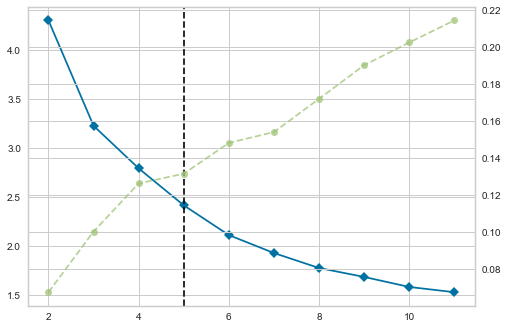

In [18]:
visualizer = KElbowVisualizer(kmeans, k=(2,12))
visualizer.fit(depmt_groupe_5metr)   

In [19]:
kmeans = cluster.KMeans(n_clusters=3, max_iter=1000)#on choisit trois clusters car le gain du troisième est considérable
depmt_app_5b=clustering(depmt_groupe_5metr.fillna(0))
depmt_app_5b=depmt_app_5b.drop_duplicates()#on supprime les doublons créés par les changements de nom
depmt_groupe_5metr=depmt_groupe_5metr.drop_duplicates()#de même ici

centres=pd.DataFrame(kmeans.cluster_centers_, index=['0','1','2'],columns=gros_groupe_5b)
pd.set_option('display.max_columns', None)
display(centres)

0.3908261234555817


,Union pour la nouvelle République,Républicains populaires et centre démocratique,Unité de la République,Non inscrit,Indépendants et paysans d'action sociale,Entente démocratique,Socialiste,Communiste,Union pour la nouvelle République-UDT,Centre démocratique,Rassemblement démocratique,Républicains indépendants,Union démocratique pour la V° République,Progrès et démocratie moderne,Fédération de la gauche démocrate et socialiste,Union des démocrates pour la République,Parti socialiste et radicaux de gauche,Union centriste,Union des démocrates pour la République,Réformateurs démocrates sociaux,Rassemblement pour la République,Union pour la démocratie française,Socialiste,Apparenté socialiste,Front national,Union du centre,Union pour la démocratie française et du centre,République et liberté,Union pour un mouvement populaire,Union pour la majorité présidentielle,Communistes et républicains
0,0.603056,1.734723e-18,0.000000e+00,0.000000,0.167022,0.071429,0.040867,0.066453,0.051173,1.734723e-18,-1.734723e-18,0.000000,6.938894e-18,1.734723e-18,0.000000,0.000000,0.000000,8.673617e-19,0.000000,8.673617e-19,1.387779e-17,0.000000,0.000000,0.000000,0.000000,4.336809e-19,0.000000,0.000000,-4.336809e-19,0.000000,2.168404e-19
1,0.036364,1.439200e-02,4.273504e-04,0.023851,0.023069,0.006405,0.046591,0.012839,0.042195,1.786117e-02,9.689315e-03,0.053914,4.998564e-02,1.995915e-02,0.017020,0.088426,0.008150,1.231945e-02,0.002615,7.213951e-03,1.571755e-01,0.123941,0.096829,0.005370,0.002159,5.689887e-03,0.039745,0.002491,3.926523e-03,0.060273,6.355985e-04
2,0.025122,7.943362e-03,-1.084202e-19,0.016773,0.015321,0.007937,0.162618,0.077218,0.021478,2.488640e-03,1.386661e-02,0.014773,1.138521e-02,8.731705e-03,0.066691,0.050552,0.041603,1.525017e-03,0.004294,5.503191e-03,8.008930e-02,0.044370,0.208837,0.012154,0.003953,1.330587e-03,0.033653,0.003260,4.528012e-03,0.036240,3.111165e-03


Les résultats sont ici plus intéressants, avec un groupe très lié à l'Union pour la nouvelle République (parti gaulliste).

<AxesSubplot:>

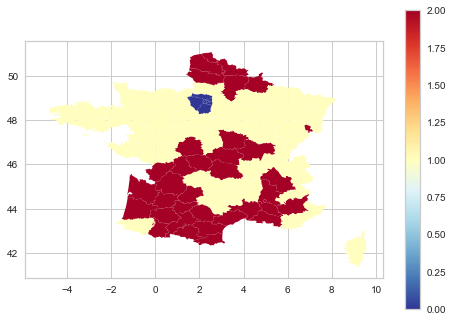

In [20]:
depmt_app_5b=depmt_app_5b[depmt_app_5b.index.notna()]
df = carte_metrop_5.merge(depmt_app_5b, how = 'inner', left_index=True, right_index=True)
df.plot(column = 'Appartenance', cmap = 'RdYlBu_r', legend=True)#on crée la carte

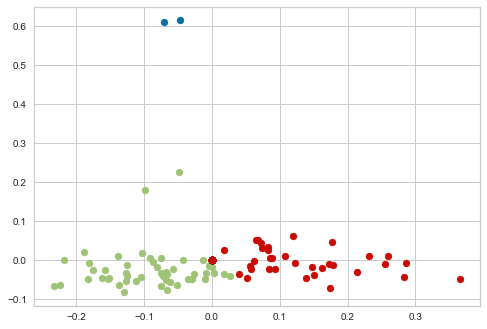

In [21]:

depmt_groupe_5metr=depmt_groupe_5metr[depmt_groupe_5metr[' Non inscrit'].notna()]#on enlève les colonies sans données
proj=acp.fit_transform(depmt_groupe_5metr)
#df.drop(['code_insee', 'nuts3', 'wikipedia', 'geometry'], axis='columns', inplace=True)
nuagepoint(depmt_app_5b, nbre_cluster=3)


On a toujours le groupe parisien votant Union pour la Nouvelle République qui se détache, le reste est plus fluctuant

Pour l'Empire !

In [22]:
kmeans = cluster.KMeans(n_clusters=2, max_iter=1000)#vu le faible nombre de grands partis, deux clusters sont suffisants
mandat_dep_emp2=mandat_dep[mandat_dep['Régime politique']=='Second Empire - Corps législatif']
(depmt_groupe_emp2, gros_groupe_emp2)=datagroupe(mandat_dep_emp2)
depmt_app_emp2=clustering(depmt_groupe_emp2.fillna(0))
centres=pd.DataFrame(kmeans.cluster_centers_, index=['0','1'],columns=gros_groupe_emp2)
pd.set_option('display.max_columns', None)
display(centres)

0.24605090932987722


,Centre droit,Opposition,Centre gauche,Gauche,Majorité dynastique,Tiers-parti,Majorité dynastique,Indépendant
0,0.108212,0.033685,0.053430,0.050777,0.541176,0.024792,0.034291,0.130778
1,0.109224,0.002430,0.018565,0.013089,0.815813,0.012184,0.001149,0.012420


In [23]:
plusgrandecart=centres.T
plusgrandecart['ecart']=plusgrandecart['0']-plusgrandecart['1']
plusgrandecart.sort_values(by='ecart')

,0,1,ecart
Majorité dynastique,0.541176,0.815813,-0.274637
Centre droit,0.108212,0.109224,-0.001012
Tiers-parti,0.024792,0.012184,0.012608
Opposition,0.033685,0.002430,0.031255
Majorité dynastique,0.034291,0.001149,0.033142
Centre gauche,0.053430,0.018565,0.034865
Gauche,0.050777,0.013089,0.037689
Indépendant,0.130778,0.012420,0.118358


Un groupe clairement pro-pouvoir, l'autre qui regroupe les mécontents (le centre droit faisant office d'entre-deux)

<AxesSubplot:>

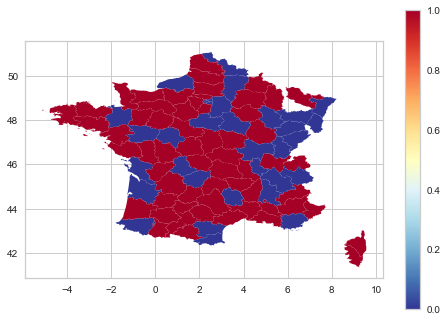

In [24]:
depmt_app_emp2.index=[i[1:] for i in depmt_app_emp2.index]#on commence par enlever l'espace qui est au début du nom des départements
df = carte_metrop.merge(depmt_app_emp2, how = 'inner', left_index=True, right_index=True)
df.plot(column = 'Appartenance', cmap = 'RdYlBu_r', legend=True)#on crée la carte

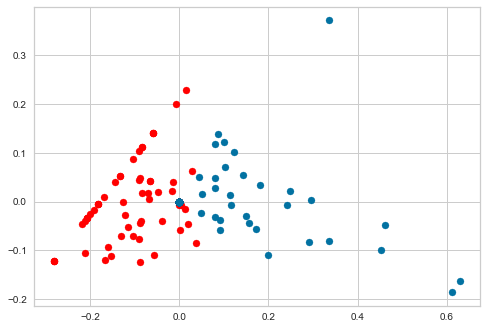

In [25]:
proj=acp.fit_transform(depmt_groupe_emp2)
nuagepoint(depmt_app_emp2)

On voit bien une séparation entre les deux groupes ici également.

In [26]:
acp.components_#comme il y a peu de grands partis, on peut regarder facilement les vecteurs propres de l'ACP.

array([[-0.01245552,  0.09971621,  0.12341285,  0.12435676, -0.89625841,
         0.08970181,  0.070648  ,  0.37800728],
       [ 0.83922823, -0.05123824, -0.18827126, -0.12595902, -0.20966967,
        -0.12329484,  0.22178893, -0.36524726]])

Le vote pour la majorité dynastique est largement l'élément contributif au plus grand vecteur propre : il est donc correct d'analyser la séparation opérée par le clustering comme une séparation entre départements pro-régime et ceux davantage liés à l'opposition.

Nouveau clustering, cette fois-ci sur les départaments

In [27]:
dpartement=ddpartement.set_index('Unnamed: 0')[0:4]

In [28]:
dpartement=dpartement.dropna(axis=1)
dpartement=dpartement.T[dpartement.T["nombre_mandat"]>40]

In [29]:
sc = StandardScaler()
centre_red=sc.fit_transform(dpartement)#on centre et réduit les données pour éviter l'effet de taille 
#du nombre de députés par rapport aux ratios par exemple

In [30]:
centre_red=pd.DataFrame(centre_red, index=dpartement.index)

In [31]:
centre_red.head(2)

,0,1,2,3
Territoire-de-Belfort,-0.969324,-1.266135,-1.228411,0.303419
Ille-et-Vilaine,-0.819475,1.154130,0.725879,1.293571


In [32]:
carte_metrop = carte_departement.loc[0:95]#on enlève les départements d'outre-mer pour avoir une carte lisible
carte_metrop.set_index('nom', inplace=True)#on met le nom du département en index pour pouvoir joindre les bases

C:\Users\sylva\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

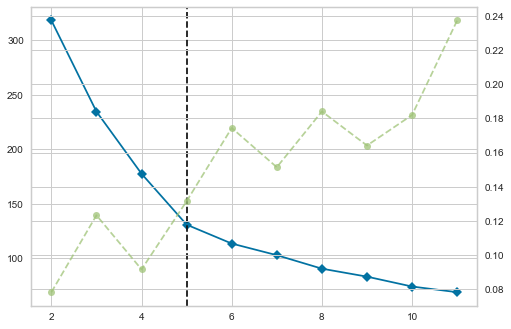

In [33]:
visualizer.fit(centre_red)   

In [34]:
kmeans = cluster.KMeans(n_clusters=5, max_iter=10000)
centre_red_clust=clustering(centre_red.fillna(0))

3.637914969271256


In [36]:
centre_red_clust.index=[i[1:] for i in centre_red.index]#on commence par enlever l'espace qui est au début du nom des départements

,code_insee,nuts3,wikipedia,geometry
nom,,,,
Ain,01,FR711,fr:Ain (département),"POLYGON ((5.25559 45.78459, 5.23987 45.77758, ..."


In [37]:
df = carte_metrop.merge(centre_red_clust, how = 'inner', left_index=True, right_index=True)

<AxesSubplot:>

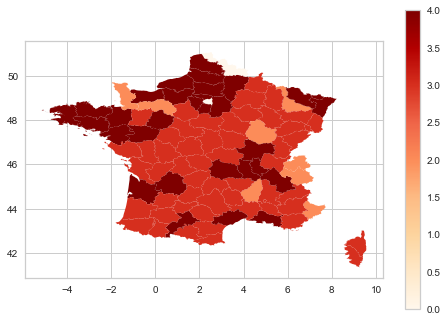

In [43]:
df.plot(column = 'Appartenance', legend=True, cmap='OrRd')#on crée la carte

In [39]:
dpartement.index=[i[1:] for i in dpartement.index]

In [40]:
analyse=dpartement.join(df["Appartenance"],how='inner')

In [41]:
analyse.groupby("Appartenance").median()

,age moyen des deputes,nombre_mandat,nombre député,nombre moyen de mandats par député
Appartenance,,,,
0,48.768821,1635.0,804.0,2.033582
2,52.509394,299.0,118.0,2.568654
3,48.358941,276.0,125.0,2.262069
4,49.147059,479.5,207.5,2.253323


On peut remarquer un groupe concentrant les départements ayant le plus de députés, et un autre ayant des députés plus âgés et plus souvent réélu, que l'on peut interpréter comme des départements "conservateurs" au sens où ils ont moins de renouvellement de leurs élus.

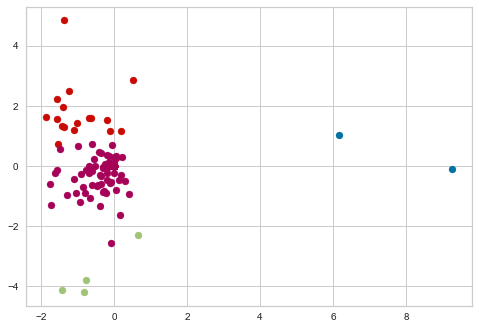

In [42]:
proj=acp.fit_transform(centre_red)
nuagepoint(centre_red_clust, nbre_cluster=4)

On voit assez bien que deux groupes ont des caractéristiques assez extrêmes, alors que les autres sont plus centrées